In [1]:
# start date 22/6/2023

import numpy as np
import math
import pandas as pd
import cv2
import os
#import tqdm
#from scipy.io import loadmat

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from PIL import Image
# import pytesseract

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K

# from utils import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.layers import *

# from keras.applications import MobileNetV2
# from keras.applications import InceptionResNetV2

from keras.models import Model
from keras.models import model_from_json
from keras import regularizers

#from keras.initializers import he_normal

from keras.models import load_model
from math import sqrt


In [2]:
target_size = [500, 700]

target_w = 700 # target sizes of image in model input
target_h = 500 #target sizes of image in model input

class_num = 1     ## item

categories = ['bom'] # details of classes

In [3]:
# Loading output of VGG Image Annotation tool and create a dataframe

region_data = []
r_data = pd.DataFrame()

for i in range(1, 28):
    via_folder = '/Users/subrata/workstation/jupyterFiles/yolo_data_file/via_region_data_drg_test_' + str(i) + '.csv'
    region = pd.read_csv(via_folder)
    region_data.append(region)
    
r_data = pd.concat(region_data).reset_index()

r_data_master = r_data[~r_data['region_shape_attributes'].str.contains('{}')].reset_index(drop=True) # remove drgs having no bbox info
r_data_master_unique = r_data_master.drop_duplicates('#filename', keep=False).reset_index(drop=True) # remove duplicate rows
r_data_master_unique.drop(r_data_master_unique.columns[[0, 2, 3, 4, 5]], axis=1, inplace=True) # reduce unnecessary columns

num_images_in_data_master = r_data_master_unique["#filename"].nunique()
r_data_master_image_list = r_data_master_unique["#filename"].tolist()


In [4]:
print(r_data_master_unique.isnull().any())   ## check whether any Nan value in any cell
print('==============')
print(r_data_master_unique.eq(0).any())  ## check whether any '0' value in any cell


#filename                  False
region_shape_attributes    False
region_attributes          False
dtype: bool
#filename                  False
region_shape_attributes    False
region_attributes          False
dtype: bool


In [5]:
## make an image list

num_image_folder = []
drg_image = []

for i in range(1, 28):
    drg_folder = 'drg_test_' + str(i)
    drg_directory = '/Users/subrata/workstation/jupyterFiles/yolo_data_file/' + drg_folder
    inter_var_1 = drg_directory + '/{}'
    drg_folder = [inter_var_1.format(i) for i in os.listdir(drg_directory)]
    num_image_folder.append(len(drg_folder))
    drg_image.append(drg_folder)

print('Number of images in folders = ', num_image_folder)
num_images = len(drg_image)
print('Number of image folders = ', num_images)


Number of images in folders =  [36, 36, 36, 42, 36, 41, 35, 54, 54, 40, 106, 54, 61, 53, 98, 97, 95, 99, 12, 32, 45, 45, 45, 47, 46, 66, 58]
Number of image folders =  27


In [6]:
## drg_image above is a list of lists. We need to flatten this and create a dataframe: 

from itertools import chain

drg_image_path_df = pd.DataFrame()

k = list(chain.from_iterable(map(list, drg_image)))
drg_image = k
drg_image.sort() # Sorting the list

drg_image_path_values = pd.Series(drg_image)
drg_image_path_df.insert(loc=0, column='i_path', value = drg_image_path_values)

drg_image_path_df.tail(3)


,i_path
1466,/Users/subrata/workstation/jupyterFiles/yolo_d...
1467,/Users/subrata/workstation/jupyterFiles/yolo_d...
1468,/Users/subrata/workstation/jupyterFiles/yolo_d...


In [7]:
# remove duplicate drawings across folders and create a column for only drg. no.

drg_image_path_df['drg_no'] = drg_image_path_df['i_path'].apply(lambda x: x.split('/')[-1])
drg_image_path_df = drg_image_path_df.drop_duplicates(subset='drg_no').reset_index(drop=True)
# drg_image_path_df = drg_image_path_df.drop('drg_no', axis=1)
drg_image_path_df.tail(3)

,i_path,drg_no
1453,/Users/subrata/workstation/jupyterFiles/yolo_d...,10834-2-20-SWZ-01-11-Model-page-001.jpg
1454,/Users/subrata/workstation/jupyterFiles/yolo_d...,10834-2-20-SWZ-04-00-Model-page-001.jpg
1455,/Users/subrata/workstation/jupyterFiles/yolo_d...,10834-2-20-SWZ-04-02-Model-page-001.jpg


In [8]:
# merge two data frames on drg.no. or file name and create a combined dataframe with required columns :

merged_drg_data = pd.merge(drg_image_path_df.rename(columns={'drg_no': '#filename'}), r_data_master_unique, on='#filename')
merged_drg_data.tail(3)


,i_path,#filename,region_shape_attributes,region_attributes
1429,/Users/subrata/workstation/jupyterFiles/yolo_d...,10834-2-20-SWZ-01-11-Model-page-001.jpg,"{""name"":""rect"",""x"":1161,""y"":513,""width"":500,""h...","{""text"":""bom""}"
1430,/Users/subrata/workstation/jupyterFiles/yolo_d...,10834-2-20-SWZ-04-00-Model-page-001.jpg,"{""name"":""rect"",""x"":1051,""y"":709,""width"":608,""h...","{""text"":""bom""}"
1431,/Users/subrata/workstation/jupyterFiles/yolo_d...,10834-2-20-SWZ-04-02-Model-page-001.jpg,"{""name"":""rect"",""x"":1138,""y"":874,""width"":517,""h...","{""text"":""bom""}"


In [51]:
r_size = merged_drg_data.values[1431, 2][1:(len(merged_drg_data.values[1431, 2])-1)]
r_size_par = r_size.split(",")
print(r_size_par)

['"name":"rect"', '"x":1138', '"y":874', '"width":517', '"height":71']


In [9]:
# Making a dataframe for Image_id, image path, x, y, width, height, class, image_width, image_height :

x = []  # co-ordinate of bbox left-top corner (and NOT center of bbox) as given by via
y = []  # co-ordinate of bbox left-top corner (and NOT center of bbox) as given by via
width = []  # of boundary box
height = []  # of boundary box
obj_class = []
i_width = []
i_height = []
img_path = []

for i in range(len(merged_drg_data)):
    
    # for x, y, width, height :
    r_size = merged_drg_data.values[i, 2][1:(len(merged_drg_data.values[i, 2])-1)]
    r_size_par = r_size.split(",")
    x.append(int("".join(filter(str.isdigit, r_size_par[1]))))
    y.append(int("".join(filter(str.isdigit, r_size_par[2]))))
    width.append(int("".join(filter(str.isdigit, r_size_par[3]))))
    height.append(int("".join(filter(str.isdigit, r_size_par[4]))))
    
    # for object class :
    r_attribs = merged_drg_data.values[i, 3][1:(len(merged_drg_data.values[i, 3])-1)]
    if r_attribs == '':
        this_class = 0
    else:
        this_class = 1
    obj_class.append(this_class)
    
    # for image width, height :
    foto_path = merged_drg_data.values[i,0]
    bgr_image = cv2.imread(foto_path)
    image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    i_ht, i_wd, _ = image.shape
    i_height.append(i_ht)
    i_width.append(i_wd)

# making the dataframe :    
x_values = pd.Series(x)
y_values = pd.Series(y)
width_values = pd.Series(width)
height_values = pd.Series(height)
class_values = pd.Series(obj_class)
i_width_values = pd.Series(i_width)
i_height_values = pd.Series(i_height)

merged_drg_data.insert(loc=2, column='x', value=x_values)
merged_drg_data.insert(loc=3, column='y', value=y_values)
merged_drg_data.insert(loc=4, column='width', value=width_values)
merged_drg_data.insert(loc=5, column='height', value=height_values)
merged_drg_data.insert(loc=6, column='obj_class', value=class_values)
merged_drg_data.insert(loc=7, column='img_wd', value=i_width_values)
merged_drg_data.insert(loc=8, column='img_ht', value=i_height_values)

merged_drg_data.drop(merged_drg_data.columns[[9, 10]], axis=1, inplace=True) # reduce unnecessary columns
merged_drg_data.rename({'#filename': 'img_id'}, axis=1, inplace=True) # changing column name

merged_drg_data.tail(3)


,i_path,img_id,x,y,width,height,obj_class,img_wd,img_ht
1429,/Users/subrata/workstation/jupyterFiles/yolo_d...,10834-2-20-SWZ-01-11-Model-page-001.jpg,1161,513,500,426,1,1754,1240
1430,/Users/subrata/workstation/jupyterFiles/yolo_d...,10834-2-20-SWZ-04-00-Model-page-001.jpg,1051,709,608,229,1,1754,1240
1431,/Users/subrata/workstation/jupyterFiles/yolo_d...,10834-2-20-SWZ-04-02-Model-page-001.jpg,1138,874,517,71,1,1754,1240


In [10]:
# find drawing of maximum size
df = merged_drg_data.sort_values('img_wd', ascending=False)
df.head(5)

,i_path,img_id,x,y,width,height,obj_class,img_wd,img_ht
336,/Users/subrata/workstation/jupyterFiles/yolo_d...,5305-7-14-FRF-01-07-Model-page-001.jpg,7391,4191,2107,1335,1,10200,6600
335,/Users/subrata/workstation/jupyterFiles/yolo_d...,5305-7-14-FRF-01-06 SH1-Model-page-001.jpg,7345,2855,2153,2648,1,10200,6600
332,/Users/subrata/workstation/jupyterFiles/yolo_d...,5305-7-14-FRF-01-03 SH1-Model-page-001.jpg,5894,2774,3511,2302,1,10200,6600
468,/Users/subrata/workstation/jupyterFiles/yolo_d...,7015-1-16-FRF-06-02-Model-page-001.jpg,3323,1248,1414,1438,1,4963,3508
17,/Users/subrata/workstation/jupyterFiles/yolo_d...,1018.jpg,2044,1707,2631,643,1,4963,3508


In [11]:
#since there is huge gap between highest and the next size and qty of highest size is only 3, we shall
# discard these three for the time being 
merged_drg_data.drop(index=[332, 335, 336], inplace=True)
merged_drg_data.reset_index(drop=True, inplace=True)
merged_drg_data.tail(3)

,i_path,img_id,x,y,width,height,obj_class,img_wd,img_ht
1426,/Users/subrata/workstation/jupyterFiles/yolo_d...,10834-2-20-SWZ-01-11-Model-page-001.jpg,1161,513,500,426,1,1754,1240
1427,/Users/subrata/workstation/jupyterFiles/yolo_d...,10834-2-20-SWZ-04-00-Model-page-001.jpg,1051,709,608,229,1,1754,1240
1428,/Users/subrata/workstation/jupyterFiles/yolo_d...,10834-2-20-SWZ-04-02-Model-page-001.jpg,1138,874,517,71,1,1754,1240


In [12]:
def single_image_info(lines):
    
    ## lines will be a dataframe like, for i in range(num_images), lines = r_new_data[i*5:(i+1)*5]
    
    pic_path = lines.iat[0, 0]
    img_width = lines.iat[0, 7].astype(np.float32)
    img_height = lines.iat[0, 8].astype(np.float32)
    
    boxes = []
    labels = []
    for i in range(len(lines)):
        
        label = lines['obj_class'][i]
        x_cen, y_cen, wide, high = float(lines.iat[i,2]+lines.iat[i,4]*0.5), float(lines.iat[i,3]+lines.iat[i,5]*0.5), float(lines.iat[i,4]), float(lines.iat[i,5])
        boxes.append([x_cen, y_cen, wide, high])
        labels.append(label)
        
    boxes = np.asarray(boxes, np.float32)
    labels = np.asarray(labels, np.float32)
    
    return pic_path, boxes, labels, img_width, img_height  ## boxes are in format xcen, ycen, width, height


In [13]:
## Creating the complete data set :

all_image_line = []
limit_lower = 0
limit_upper = 0

for i in range(len(merged_drg_data)):

    image_line = []
    
    img = merged_drg_data['img_id'][limit_upper]
    kount = merged_drg_data['img_id'].value_counts()[img]    ## this gives no. of same images with region data of multiple categories
       
    limit_lower = limit_upper
    limit_upper = limit_lower + kount
    
    lines = merged_drg_data[limit_lower:limit_upper].reset_index(drop=True)
    """
    print('===================', i)
    print(img)
    print(limit_lower)
    print(limit_upper)
    """
    
    pic_path, boxes, labels, img_width, img_height = single_image_info(lines)
                                    
    image_line.append(pic_path)                  ## pic_path = path of the image
    image_line.append(boxes)                     ## boxes are in format x_cen, y_cen, width, height
    image_line.append(labels)                    ## labels are either 1 or 0
    image_line.append(img_width)
    image_line.append(img_height)
    all_image_line.append(image_line)
    
print(len(all_image_line))
print(all_image_line[1428])   ##  boxes are in format xcen, ycen, width, height

1429
['/Users/subrata/workstation/jupyterFiles/yolo_data_file/drg_test_9/10834-2-20-SWZ-04-02-Model-page-001.jpg', array([[1396.5,  909.5,  517. ,   71. ]], dtype=float32), array([1.], dtype=float32), 1754.0, 1240.0]


In [14]:
# Train and Test split

data_train_val, data_test = train_test_split(all_image_line, train_size = 0.9 , shuffle = True)
data_train, data_val = train_test_split(data_train_val, train_size = 0.80 , shuffle = True)

num_all_bbox = len(all_image_line) * len(all_image_line[0][2])
num_bb_train = len(data_train) * len(data_train[0][2])
num_bb_val = len(data_val) * len(data_val[0][2])
num_bb_test = len(data_test) * len(data_test[0][2])
print(num_all_bbox, num_bb_train, num_bb_val, num_bb_test)

1429 1028 258 143


In [15]:
y_true = np.zeros((1,5), np.float32)
y_true.shape

(1, 5)

In [31]:
image_index = []
image_resized = []
image_y_true = []

for i in range(len(data_train)):

    y_true = np.zeros((5), np.float32)
    img_resized = np.zeros((target_size[0], target_size[1]), np.float32)

    y_true[0] = data_train[i][2][0]
    y_true[1] = data_train[i][1][0][0] / data_train[i][3]
    y_true[2] = data_train[i][1][0][1] / data_train[i][4]
    y_true[3] = data_train[i][1][0][2] / data_train[i][3]
    y_true[4] = data_train[i][1][0][3] / data_train[i][4]

    image_y_true.append(y_true)

    bw_img = cv2.imread(data_train[i][0], cv2.IMREAD_GRAYSCALE)
    # img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(bw_img,(target_size[0], target_size[1]), interpolation=cv2.INTER_CUBIC)
    img_resized = img_resized / 255.0
    img_resized = img_resized.reshape((500, 700, 1))

    image_resized.append(img_resized)

X_train = np.array(image_resized).astype(np.float32)
Y_train = np.array(image_y_true).astype(np.float32)   

In [32]:
print(X_train.shape)
print(Y_train.shape)

(1028, 500, 700, 1)
(1028, 5)


In [34]:
image_index = []
image_resized = []
image_y_true = []

for i in range(len(data_val)):

    y_true = np.zeros((5), np.float32)
    img_resized = np.zeros((target_size[0], target_size[1]), np.float32)
    
    y_true[0] = data_val[i][2][0]
    y_true[1] = data_val[i][1][0][0] / data_val[i][3]
    y_true[2] = data_val[i][1][0][1] / data_val[i][4]
    y_true[3] = data_val[i][1][0][2] / data_val[i][3]
    y_true[4] = data_val[i][1][0][3] / data_val[i][4]

    image_y_true.append(y_true)

    bw_img = cv2.imread(data_val[i][0], cv2.IMREAD_GRAYSCALE)
    # img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(bw_img,(target_size[0], target_size[1]), interpolation=cv2.INTER_CUBIC)
    img_resized = img_resized / 255.0
    img_resized = img_resized.reshape((500,700,1))

    image_resized.append(img_resized)

X_val = np.array(image_resized).astype(np.float32)
Y_val = np.array(image_y_true).astype(np.float32)   

In [19]:
image_index = []
image_resized = []
image_y_true = []

for i in range(len(data_test)):

    y_true = np.zeros((1,5), np.float32)
    img_resized = np.zeros((target_size[0], target_size[1]), np.float32)

    y_true[0][0] = data_test[i][2][0]
    y_true[0][1] = data_test[i][1][0][0] / data_test[i][3]
    y_true[0][2] = data_test[i][1][0][1] / data_test[i][4]
    y_true[0][3] = data_test[i][1][0][2] / data_test[i][3]
    y_true[0][4] = data_test[i][1][0][3] / data_test[i][4]

    image_y_true.append(y_true)

    bw_img = cv2.imread(data_test[i][0], cv2.IMREAD_GRAYSCALE)
    # img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(bw_img,(target_size[0], target_size[1]), interpolation=cv2.INTER_CUBIC)
    img_resized = img_resized / 255.0
    img_resized = img_resized.reshape((500,700,1))

    image_resized.append(img_resized)

X_test = np.array(image_resized).astype(np.float32)
Y_test = np.array(image_y_true).astype(np.float32)   

In [35]:

def make_my_model_1():
# Define input layer
    inputs = Input(shape=(500, 700, 1))

    # Add first conv2D layer
    x = Conv2D(32, (3, 3), strides=1, padding='same')(inputs)
    # x = Conv2D(16, (5, 5), strides=1)(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Add second conv2D layer
    x = Conv2D(64, (3, 3), strides=2, padding='valid')(x)
    # x = Conv2D(32, (3, 3), strides=2)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Add third conv2D layer
    x = Conv2D(32, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Add fourth conv2D layer
    x = Conv2D(128, (3, 3), strides=2, padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), strides=2, padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(32, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # Flatten and add fully connected layer
    x = Flatten()(x)
    y = Dense(1, activation='sigmoid', name='cls_output')(x)
    z = Dense(4, activation = 'linear', name='loc_output')(x)
    y_z = concatenate([y,z])
    # final = Reshape((1,5))(y_z)

    # Create model
    model = Model(inputs, y_z)

    return model



In [53]:
my_model_3= make_my_model_1()
print(my_model_3.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 500, 700, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 500, 700, 32  320         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_20 (BatchN  (None, 500, 700, 32  128        ['conv2d_20[0][0]']              
 ormalization)                  )                                                           

In [48]:
def convert_to_corners(y_old):
    obj_class, x_center, y_center, width, height = tf.unstack(y_old, axis=1)
    # print(x_center, 'and', width)
    x_min = x_center - width / 2.
    y_min = y_center - height / 2.
    x_max = x_center + width / 2.
    y_max = y_center + height / 2.

    y_revised = tf.stack([obj_class, x_min, y_min, x_max, y_max], axis=1)

    return y_revised


In [44]:
convert_to_corners(Y_train[0])

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([1.        , 0.5932155 , 0.5288423 , 0.94840366, 0.76280755],
      dtype=float32)>

In [37]:
#calculate iou between target box and predicted box

def iou(y_true, y_pred):
    # Extracting coordinates from tensors

    y_true_rev = convert_to_corners(y_true)
    y_pred_rev = convert_to_corners(y_pred)

    # print(y_true_rev.shape)

    true_box = tf.squeeze(y_true_rev[..., 1:])
    pred_box = tf.squeeze(y_pred_rev[..., 1:])

    # print(true_box.shape)

    # Calculating intersection coordinates
    xi1 = tf.maximum(true_box[..., 0], pred_box[..., 0])
    yi1 = tf.maximum(true_box[..., 1], pred_box[..., 1])
    xi2 = tf.minimum(true_box[..., 0] + true_box[..., 2], pred_box[..., 0] + pred_box[..., 2])
    yi2 = tf.minimum(true_box[..., 1] + true_box[..., 3], pred_box[..., 1] + pred_box[..., 3])

    # Calculating intersection area
    inter_area = tf.maximum((xi2 - xi1), 0.0) * tf.maximum((yi2 - yi1), 0.0)

    # Calculating union area
    true_area = true_box[..., 2] * true_box[..., 3]
    pred_area = pred_box[..., 2] * pred_box[..., 3]
    union_area = true_area + pred_area - inter_area
    # print('union_area =', union_area)
    # Calculating IOU
    iou = inter_area / K.maximum(union_area, K.epsilon())
    
    return iou, union_area



In [ ]:
# class loss
gamma = 2
iou = iou(y_true, y_pred)

if y_true[..., :1] == 1:
    f_iou = 1-(1-iou) ** gamma
else:
    f_iou = (1-iou) ** gamma 
bce = tf.keras.losses.BinaryCrossentropy()
cls_loss = f_iou * bce(y_true[..., :1], y_pred[..., :1]).numpy()

In [44]:


def classification_loss(y_true, y_pred):
    # Extract the object label and bounding box coordinates
    y_true_cls = y_true[:, :, 0]
    y_pred_cls = y_pred[:, :, 0]

    # Calculate the intersection over union (IoU)
    x_true_min = y_true[:, :, 1]
    y_true_min = y_true[:, :, 2]
    w_true = y_true[:, :, 3]
    h_true = y_true[:, :, 4]
    x_pred_min = y_pred[:, :, 1]
    y_pred_min = y_pred[:, :, 2]
    w_pred = y_pred[:, :, 3]
    h_pred = y_pred[:, :, 4]
    xA = K.maximum(x_true_min, x_pred_min)
    yA = K.maximum(y_true_min, y_pred_min)
    xB = K.minimum(x_true_min + w_true, x_pred_min + w_pred)
    yB = K.minimum(y_true_min + h_true, y_pred_min + h_pred)
    interArea = K.maximum(0.0, xB - xA) * K.maximum(0.0, yB - yA)
    boxAArea = w_true * h_true
    boxBArea = w_pred * h_pred
    iou = interArea / (boxAArea + boxBArea - interArea)

    # Calculate the focal loss
    alpha = 0.25
    gamma = 2.0
    eps = K.epsilon()
    pt_1 = tf.where(K.equal(y_true_cls, 1), y_pred_cls, tf.ones_like(y_pred_cls))
    pt_0 = tf.where(K.equal(y_true_cls, 0), y_pred_cls, tf.zeros_like(y_pred_cls) + eps)
    pt_1 = K.clip(pt_1, eps, 1 - eps)
    pt_0 = K.clip(pt_0, eps, 1 - eps)
    loss = -K.mean(alpha * K.pow(1 - pt_1, gamma) * K.log(pt_1) \
                + (1 - alpha) * K.pow(pt_0, gamma) * K.log(1 - pt_0))

    # Apply the focal loss factor based on the IoU
    focal_factor = K.pow((1 - iou), gamma)
    loss = loss * focal_factor

    # Calculate the positive and negative examples counts
    num_positives = K.sum(y_true_cls)
    num_negatives = K.sum(1 - y_true_cls)

    # Balance the loss between positive and negative examples
    beta = num_negatives / (num_negatives + num_positives + eps)
    balanced_loss = beta * loss + (1 - beta) * K.mean(loss * y_true_cls)

    return balanced_loss

    



In [49]:
# localisation loss based on DIou
# https://arxiv.org/pdf/2011.05523.pdf#:~:text=The%20loss%20functions%20of%20object,box%20to%20locate%20target%20object.

def DIoU_loss(y_true, y_pred):
    
    true_class, x_true_cen, y_true_cen, width_true, height_true = tf.unstack(y_true, axis=1)
    pred_class, x_pred_cen, y_pred_cen, width_pred, height_pred = tf.unstack(y_pred, axis=1)

    diou, u_area = iou(y_true, y_pred)
    c_distance = K.pow(x_true_cen - x_pred_cen, 2) + K.pow(y_true_cen - y_pred_cen, 2)

    # Calculate DIoU loss
    # diou = intersection_area / K.maximum(union_area, K.epsilon())

    iou_distance = diou - K.clip((c_distance / u_area), 0, 1)
    diou_loss = 1 - iou_distance
    return diou_loss


In [51]:
from keras.callbacks import LearningRateScheduler

def step_decay(epoch, initial_lr, drop, epochs_drop):
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

#from tensorflow.keras.callbacks import LearningRateScheduler

initial_learning_rate = 0.0001
lr_decay = 0.1
epochs_drop = 15

# Define the learning rate schedule using the step decay function
lr_scheduler = LearningRateScheduler(lambda epoch: step_decay(epoch, initial_learning_rate, lr_decay, epochs_drop))


In [47]:
from tensorflow.keras.optimizers import SGD

opt = SGD(learning_rate=0.001)

my_model_1.compile(optimizer=opt, loss={'cls_output': classification_loss, 'loc_output': DIoU_loss})


In [48]:
history = my_model_1.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val), callbacks=[lr_scheduler])


Epoch 1/50


ValueError: in user code:

    File "/Users/subrata/.pyenv/versions/3.9.15/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/Users/subrata/.pyenv/versions/3.9.15/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/subrata/.pyenv/versions/3.9.15/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/Users/subrata/.pyenv/versions/3.9.15/lib/python3.9/site-packages/keras/engine/training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/subrata/.pyenv/versions/3.9.15/lib/python3.9/site-packages/keras/engine/training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "/Users/subrata/.pyenv/versions/3.9.15/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 240, in __call__
        self.build(y_pred)
    File "/Users/subrata/.pyenv/versions/3.9.15/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 181, in build
        self._losses = self._conform_to_outputs(y_pred, self._losses)
    File "/Users/subrata/.pyenv/versions/3.9.15/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 60, in _conform_to_outputs
        struct = map_to_output_names(outputs, self._output_names, struct)
    File "/Users/subrata/.pyenv/versions/3.9.15/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 805, in map_to_output_names
        raise ValueError(

    ValueError: Found unexpected losses or metrics that do not correspond to any Model output: dict_keys(['cls_output', 'loc_output']). Valid mode output names: ['reshape_2']. Received struct is: {'cls_output': <function classification_loss at 0x2d621b4c0>, 'loc_output': <function DIoU_loss at 0x2d621b3a0>}.


In [60]:
def classification_loss(gamma=2.0):

    def binary_focal_loss(y_true, y_pred):
        # Extract the object label and bounding box coordinates
        y_true_cls = y_true[:, :, 0]
        y_pred_cls = y_pred[:, :, 0]

        # Calculate the intersection over union (IoU)
        x_true_min = y_true[:, :, 1]
        y_true_min = y_true[:, :, 2]
        w_true = y_true[:, :, 3]
        h_true = y_true[:, :, 4]
        x_pred_min = y_pred[:, :, 1]
        y_pred_min = y_pred[:, :, 2]
        w_pred = y_pred[:, :, 3]
        h_pred = y_pred[:, :, 4]
        xA = K.maximum(x_true_min, x_pred_min)
        yA = K.maximum(y_true_min, y_pred_min)
        xB = K.minimum(x_true_min + w_true, x_pred_min + w_pred)
        yB = K.minimum(y_true_min + h_true, y_pred_min + h_pred)
        interArea = K.maximum(0.0, xB - xA) * K.maximum(0.0, yB - yA)
        boxAArea = w_true * h_true
        boxBArea = w_pred * h_pred
        iou = interArea / (boxAArea + boxBArea - interArea)

        # Calculate the focal loss
        alpha = 0.25
        # gamma = gamma
        eps = K.epsilon()
        pt_1 = tf.where(K.equal(y_true_cls, 1), y_pred_cls, tf.ones_like(y_pred_cls))
        pt_0 = tf.where(K.equal(y_true_cls, 0), y_pred_cls, tf.zeros_like(y_pred_cls) + eps)
        pt_1 = K.clip(pt_1, eps, 1 - eps)
        pt_0 = K.clip(pt_0, eps, 1 - eps)
        loss = -K.mean(alpha * K.pow(1 - pt_1, gamma) * K.log(pt_1) \
                    + (1 - alpha) * K.pow(pt_0, gamma) * K.log(1 - pt_0))

        # Apply the focal loss factor based on the IoU
        focal_factor = K.pow((1 - iou), gamma)
        loss = loss * focal_factor

        # Calculate the positive and negative examples counts
        num_positives = K.sum(y_true_cls)
        num_negatives = K.sum(1 - y_true_cls)

        # Balance the loss between positive and negative examples
        beta = num_negatives / (num_negatives + num_positives + eps)
        balanced_loss = beta * loss + (1 - beta) * K.mean(loss * y_true_cls)

        return balanced_loss

    return binary_focal_loss

def loca_loss(factor=1.0):

    def DIoU_loss(y_true, y_pred):
        # Extract the bounding box coordinates for both true and predicted values
        x_true_min = y_true[:, :, 1]
        y_true_min = y_true[:, :, 2]
        w_true = y_true[:, :, 3]
        h_true = y_true[:, :, 4]
        x_pred_min = y_pred[:, :, 1]
        y_pred_min = y_pred[:, :, 2]
        w_pred = y_pred[:, :, 3]
        h_pred = y_pred[:, :, 4]

        # Calculate the coordinates of the diagonal (upper left and lower right) points 
        xA = K.maximum(x_true_min, x_pred_min)
        yA = K.maximum(y_true_min, y_pred_min)
        xB = K.minimum(x_true_min + w_true, x_pred_min + w_pred)
        yB = K.minimum(y_true_min + h_true, y_pred_min + h_pred)

        # Calculate intersection area and union area
        intersection_area = K.maximum(0.0, xB - xA) * K.maximum(0.0, yB - yA)
        true_box_area = w_true * h_true
        pred_box_area = w_pred * h_pred
        union_area = true_box_area + pred_box_area - intersection_area

        # Calculate the enclosed distance between two boxes' centroids
        c_true_x = x_true_min + w_true / 2
        c_true_y = y_true_min + h_true / 2
        c_pred_x = x_pred_min + w_pred / 2
        c_pred_y = y_pred_min + h_pred / 2
        c_distance = K.pow(c_true_x - c_pred_x, 2) + K.pow(c_true_y - c_pred_y, 2)

        # Calculate the minimum distance between each side of both boxes
        wA = x_true_min + w_true - x_true_min
        hA = y_true_min + h_true - y_true_min
        wB = x_pred_min + w_pred - x_pred_min
        hB = y_pred_min + h_pred - y_pred_min
        min_distance = K.minimum(wA, wB) * 0.5 + K.minimum(hA, hB) * 0.5

        # Calculate DIoU loss
        diou = intersection_area / union_area
        diou_distance = diou - K.clip((c_distance / union_area), 0, 1)
        diou_loss = (1 - diou_distance) * factor
        return diou_loss
    return DIoU_loss

def combined_loss(gamma=2.0, factor=1.0):

    def combined_loss_fixed(y_true, y_pred):
        
        # class_true, loc_true = y_true[:, :, :1], y_true[:, :, 1:]
        # class_pred, loc_pred = y_pred[:, :, :1], y_pred[:, :, 1:]
        
        # class_loss = classification_loss(gamma=gamma)(y_true, y_pred)
        loc_loss = loca_loss(factor=factor)(y_true, y_pred)
        # combo_loss = class_loss + loc_loss
        combo_loss = loc_loss

        return combo_loss

    return combined_loss_fixed



In [27]:
from tensorflow.keras.callbacks import Callback

class PrintIntermediateValues(Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        # You can access any desired values from logs dictionary
        print("Epoch:", epoch)
        print("Loss:", logs['loss'])
        print("Validation Loss:", logs['val_loss'])
        print("x_true_min:", logs['x_true_min'])
        
# Create an instance of the callback
print_callback = PrintIntermediateValues()

opt = Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
my_model_1.compile(loss=DIoU_loss, optimizer=opt)
# Modify your training code to include the callback
history = my_model_1.fit(X_train,Y_train, epochs=5, batch_size = 16, 
                         validation_data=(X_val,Y_val), 
                         callbacks=[lr_scheduler, print_callback])


Epoch 1/5


2023-06-28 23:06:59.188516: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


65/65 [==============================] - ETA: 0s - loss: 1.0064Epoch: 0
Loss: 1.0063505172729492
Validation Loss: 1.0


KeyError: 'x_true_min'

In [26]:
epoch = 50
opt = Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
# my_model_1.compile(loss=combined_loss(gamma=2.0, factor=1.0), optimizer=opt)
my_model_1.compile(loss=DIoU_loss, optimizer=opt)
history = my_model_1.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val), callbacks=[lr_scheduler])


Epoch 1/50


2023-07-03 00:23:23.445950: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


65/65 [==============================] - 281s 4s/step - loss: 1.1648 - val_loss: 1.0489 - lr: 1.0000e-04
Epoch 2/50
65/65 [==============================] - 298s 5s/step - loss: 1.0046 - val_loss: 1.0088 - lr: 1.0000e-04
Epoch 3/50
65/65 [==============================] - 304s 5s/step - loss: 1.0016 - val_loss: 1.0021 - lr: 1.0000e-04
Epoch 4/50
65/65 [==============================] - 306s 5s/step - loss: 1.0009 - val_loss: 1.0010 - lr: 1.0000e-04
Epoch 5/50
65/65 [==============================] - 320s 5s/step - loss: 1.0006 - val_loss: 1.0009 - lr: 1.0000e-04
Epoch 6/50
65/65 [==============================] - 310s 5s/step - loss: 1.0004 - val_loss: 1.0009 - lr: 1.0000e-04
Epoch 7/50
65/65 [==============================] - 311s 5s/step - loss: 1.0003 - val_loss: 1.0006 - lr: 1.0000e-04
Epoch 8/50
65/65 [==============================] - 309s 5s/step - loss: 1.0002 - val_loss: 1.0004 - lr: 1.0000e-04
Epoch 9/50
65/65 [==============================] - 311s 5s/step - loss: 1.0002 - v

KeyboardInterrupt: 

In [29]:
epoch = 50
opt = Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
# my_model_1.compile(loss=combined_loss(gamma=2.0, factor=1.0), optimizer=opt)
my_model_2.compile(loss=DIoU_loss, optimizer=opt)
history = my_model_2.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val), callbacks=[lr_scheduler])


Epoch 1/50
65/65 [==============================] - 391s 6s/step - loss: 1.0700 - val_loss: 1.0030 - lr: 1.0000e-04
Epoch 2/50
65/65 [==============================] - 467s 7s/step - loss: 1.0025 - val_loss: 1.0012 - lr: 1.0000e-04
Epoch 3/50
65/65 [==============================] - 486s 7s/step - loss: 1.0014 - val_loss: 1.0002 - lr: 1.0000e-04
Epoch 4/50
65/65 [==============================] - 494s 8s/step - loss: 1.0009 - val_loss: 1.0001 - lr: 1.0000e-04
Epoch 5/50
65/65 [==============================] - 474s 7s/step - loss: 1.0006 - val_loss: 1.0001 - lr: 1.0000e-04
Epoch 6/50
65/65 [==============================] - 474s 7s/step - loss: 1.0004 - val_loss: 1.0001 - lr: 1.0000e-04
Epoch 7/50
65/65 [==============================] - 464s 7s/step - loss: 1.0003 - val_loss: 1.0001 - lr: 1.0000e-04
Epoch 8/50
65/65 [==============================] - 439s 7s/step - loss: 1.0001 - val_loss: 1.0002 - lr: 1.0000e-04
Epoch 9/50
65/65 [==============================] - 430s 7s/step - loss:

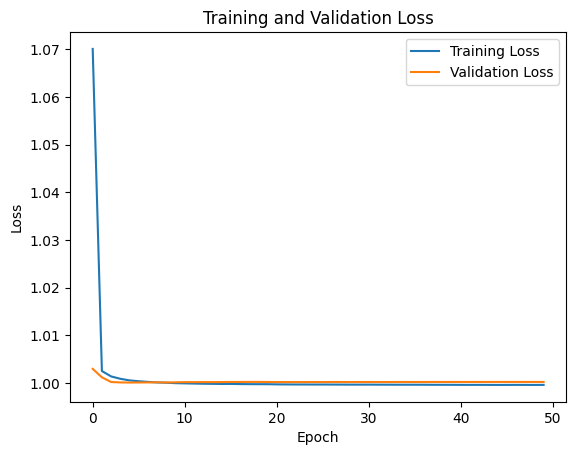

In [30]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [54]:
epoch = 50
opt = Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
# my_model_1.compile(loss=combined_loss(gamma=2.0, factor=1.0), optimizer=opt)
my_model_3.compile(loss=DIoU_loss, optimizer=opt)
history = my_model_3.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val), callbacks=[lr_scheduler])


Epoch 1/50
65/65 [==============================] - 373s 6s/step - loss: 1.0269 - val_loss: 1.0068 - lr: 1.0000e-04
Epoch 2/50
65/65 [==============================] - 400s 6s/step - loss: 1.0021 - val_loss: 1.0014 - lr: 1.0000e-04
Epoch 3/50
65/65 [==============================] - 396s 6s/step - loss: 1.0010 - val_loss: 1.0003 - lr: 1.0000e-04
Epoch 4/50
65/65 [==============================] - 399s 6s/step - loss: 1.0006 - val_loss: 1.0006 - lr: 1.0000e-04
Epoch 5/50
65/65 [==============================] - 404s 6s/step - loss: 1.0003 - val_loss: 1.0003 - lr: 1.0000e-04
Epoch 6/50
65/65 [==============================] - 393s 6s/step - loss: 1.0002 - val_loss: 1.0002 - lr: 1.0000e-04
Epoch 7/50
65/65 [==============================] - 384s 6s/step - loss: 1.0001 - val_loss: 1.0002 - lr: 1.0000e-04
Epoch 8/50
65/65 [==============================] - 387s 6s/step - loss: 1.0001 - val_loss: 1.0003 - lr: 1.0000e-04
Epoch 9/50
65/65 [==============================] - 393s 6s/step - loss:

KeyboardInterrupt: 

In [34]:
y_true = tf.constant([[1., 10., 10., 50., 50.]])
y_pred = tf.constant([[1., 20., 20., 60., 60.]])
loss = DIoU_loss(y_true, y_pred)
print(loss)


tf.Tensor([0.7522124], shape=(1,), dtype=float32)


In [ ]:
import tensorflow.keras.backend as K

def diou_loss(y_true, y_pred):
    # Extract the coordinates from y_true and y_pred
    x_true, y_true, w_true, h_true = tf.unstack(y_true, axis=1)
    x_pred, y_pred, w_pred, h_pred = tf.unstack(y_pred, axis=1)

    # Convert to top-left and bottom-right corner coordinates
    x_true_tl = x_true - w_true / 2
    y_true_tl = y_true - h_true / 2
    x_true_br = x_true + w_true / 2
    y_true_br = y_true + h_true / 2

    x_pred_tl = x_pred - w_pred / 2
    y_pred_tl = y_pred - h_pred / 2
    x_pred_br = x_pred + w_pred / 2
    y_pred_br = y_pred + h_pred / 2

    # Calculate IoU
    intersection_xmin = K.maximum(x_true_tl, x_pred_tl)
    intersection_ymin = K.maximum(y_true_tl, y_pred_tl)
    intersection_xmax = K.minimum(x_true_br, x_pred_br)
    intersection_ymax = K.minimum(y_true_br, y_pred_br)
    intersection_width = K.maximum(intersection_xmax - intersection_xmin, 0)
    intersection_height = K.maximum(intersection_ymax - intersection_ymin, 0)
    intersection_area = intersection_width * intersection_height

    true_box_area = w_true * h_true
    pred_box_area = w_pred * h_pred
    union_area = true_box_area + pred_box_area - intersection_area

    iou_loss = -K.log((intersection_area + 1.0) / (union_area + 1.0))

    # Calculate Euclidean distance
    center_distance = K.sqrt(K.square(x_true - x_pred) + K.square(y_true - y_pred))

    # Calculate DIoU loss
    alpha = 1.0  # You can adjust the value of alpha as needed
    diou_loss = iou_loss - alpha * K.square(center_distance)

    return diou_loss


In [ ]:
import tensorflow.keras.backend as K

def diou_loss(y_true, y_pred):
    # Extract the coordinates from y_true and y_pred
    x_true, y_true, w_true, h_true = tf.unstack(y_true, axis=1)
    x_pred, y_pred, w_pred, h_pred = tf.unstack(y_pred, axis=1)

    # Convert to top-left and bottom-right corner coordinates
    x_true_tl = x_true - w_true / 2
    y_true_tl = y_true - h_true / 2
    x_true_br = x_true + w_true / 2
    y_true_br = y_true + h_true / 2

    x_pred_tl = x_pred - w_pred / 2
    y_pred_tl = y_pred - h_pred / 2
    x_pred_br = x_pred + w_pred / 2
    y_pred_br = y_pred + h_pred / 2

    # Calculate IoU
    intersection_xmin = K.maximum(x_true_tl, x_pred_tl)
    intersection_ymin = K.maximum(y_true_tl, y_pred_tl)
    intersection_xmax = K.minimum(x_true_br, x_pred_br)
    intersection_ymax = K.minimum(y_true_br, y_pred_br)
    intersection_width = K.maximum(intersection_xmax - intersection_xmin, 0)
    intersection_height = K.maximum(intersection_ymax - intersection_ymin, 0)
    intersection_area = intersection_width * intersection_height

    true_box_area = w_true * h_true
    pred_box_area = w_pred * h_pred
    union_area = true_box_area + pred_box_area - intersection_area

    iou_loss = -K.log((intersection_area + 1.0) / (union_area + 1.0))

    # Calculate Euclidean distance
    center_distance = K.sqrt(K.square(x_true - x_pred) + K.square(y_true - y_pred))

    # Calculate DIoU loss
    alpha = 1.0  # You can adjust the value of alpha as needed
    diou_loss = iou_loss - alpha * K.square(center_distance)

    return diou_loss


In [ ]:
import tensorflow.keras.backend as K

def diou_loss(y_true, y_pred):
    # Extract the coordinates from y_true and y_pred
    x_true, y_true, w_true, h_true = tf.unstack(y_true, axis=1)
    x_pred, y_pred, w_pred, h_pred = tf.unstack(y_pred, axis=1)

    # Convert to top-left and bottom-right corner coordinates
    x_true_tl = x_true - w_true / 2
    y_true_tl = y_true - h_true / 2
    x_true_br = x_true + w_true / 2
    y_true_br = y_true + h_true / 2

    x_pred_tl = x_pred - w_pred / 2
    y_pred_tl = y_pred - h_pred / 2
    x_pred_br = x_pred + w_pred / 2
    y_pred_br = y_pred + h_pred / 2

    # Calculate IoU
    intersection_xmin = K.maximum(x_true_tl, x_pred_tl)
    intersection_ymin = K.maximum(y_true_tl, y_pred_tl)
    intersection_xmax = K.minimum(x_true_br, x_pred_br)
    intersection_ymax = K.minimum(y_true_br, y_pred_br)
    intersection_width = K.maximum(intersection_xmax - intersection_xmin, 0)
    intersection_height = K.maximum(intersection_ymax - intersection_ymin, 0)
    intersection_area = intersection_width * intersection_height

    true_box_area = w_true * h_true
    pred_box_area = w_pred * h_pred
    union_area = true_box_area + pred_box_area - intersection_area

    iou_loss = -K.log((intersection_area + 1.0) / (union_area + 1.0))

    # Calculate Euclidean distance
    center_distance = K.sqrt(K.square(x_true - x_pred) + K.square(y_true - y_pred))

    # Calculate DIoU loss
    alpha = 1.0  # You can adjust the value of alpha as needed
    diou_loss = iou_loss - alpha * K.square(center_distance)

    return diou_loss


In [69]:
import tensorflow.keras.backend as K

def diou_loss(y_true, y_pred):
    # Extract class labels and coordinates from y_true and y_pred
    obj_class_true, x_true, y_true, w_true, h_true = tf.unstack(y_true, axis=1)
    obj_class_pred, x_pred, y_pred, w_pred, h_pred = tf.unstack(y_pred, axis=1)

    # Convert to top-left and bottom-right corner coordinates
    x_true_tl = x_true - w_true / 2
    y_true_tl = y_true - h_true / 2
    x_true_br = x_true + w_true / 2
    y_true_br = y_true + h_true / 2

    x_pred_tl = x_pred - w_pred / 2
    y_pred_tl = y_pred - h_pred / 2
    x_pred_br = x_pred + w_pred / 2
    y_pred_br = y_pred + h_pred / 2

    # Calculate IoU
    intersection_xmin = K.maximum(x_true_tl, x_pred_tl)
    intersection_ymin = K.maximum(y_true_tl, y_pred_tl)
    intersection_xmax = K.minimum(x_true_br, x_pred_br)
    intersection_ymax = K.minimum(y_true_br, y_pred_br)
    intersection_width = K.maximum(intersection_xmax - intersection_xmin, 0)
    intersection_height = K.maximum(intersection_ymax - intersection_ymin, 0)
    intersection_area = intersection_width * intersection_height

    true_box_area = w_true * h_true
    pred_box_area = w_pred * h_pred
    union_area = true_box_area + pred_box_area - intersection_area

    iou_loss = -K.log((intersection_area + 1.0) / (union_area + 1.0))

    # Calculate Euclidean distance between centers
    center_distance = K.sqrt(K.square(x_true - x_pred) + K.square(y_true - y_pred))

    # Calculate DIoU loss
    alpha = 1.0  # You can adjust the value of alpha as needed
    diou_loss = iou_loss - alpha * K.square(center_distance)

    return diou_loss


In [87]:
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        #if conv['stride'] > 1 and conv['layer_idx'] != 37 : x = ZeroPadding2D(((1,0),(1,0)))(x)
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x


In [66]:
## MODEL which gave good result
# 5/8 dropout

def copy_yolov3_model():
    input_image = Input(shape=(500, 700, 1))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    x = Dropout(0.2)(x)
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    x = Dropout(0.2)(x)
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    x = Dropout(0.2)(x)
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    x = Dropout(0.2)(x)
    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
    
    x = Dropout(0.2)(x)
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    x = Dropout(0.2)(x)
    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x

    
        
    x = Dropout(0.2)(x)
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
    
    # Layer 62 => 65
##    x = _conv_block(x, [{'filter':  256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
##                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
##                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])


    x = Dropout(0.2)(x)
    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
    
     # Layer 66 => 74
##    for i in range(3):
##        x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
##                            {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])

    x = Dropout(0.2)(x)
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
    
    # Layer 75 => 79
##    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
##                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
##                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
##                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
##                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
    
    # Layer 80 => 82
#    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
#                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    # x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 85}])
    x = Dropout(0.2)(x)
    x = UpSampling2D(2)(x)
    """
    x = concatenate([x, skip_61])
    
    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
    x = Dropout(0.2)(x)

    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 101},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 102},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 103}], skip=False)
    x = Dropout(0.2)(x)

    # Layer 92 => 94
    # yolo_94 = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
    #                          {'filter':   18, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

#===============================================================================================================
    # Layer 95 => 980
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

#    model = Model(input_image, [yolo_82, yolo_94, yolo_106])

    #final = Reshape((grid_y_axis,grid_x_axis,3,6))(yolo_94)
    #final = Reshape((19,19,3,6))(yolo_94)
    #model = Model(input_image, final)
    x = Flatten()(yolo_106)
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.1)(x)
#    x = Dropout(0.2)(x)
    y = Dense(1, activation = 'sigmoid')(x)
    z = Dense(4, activation = 'linear')(x)
    
#    y = LeakyReLU(alpha=0.1)(x)
#    z = Dense(5)(y)

    y_z = concatenate([y,z])
#    final = Reshape((1,5))(y_z)
    
"""
    final = x
    model = Model(input_image, final)
    return model


In [102]:
# As per original model of 'experiencor'

def copy_yolov3_model():
    input_image = Input(shape=(500, 700, 1))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 5, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
       
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
        
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)

    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
    """
    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

#    model = Model(input_image, [yolo_82, yolo_94, yolo_106]) 
    
    # model_1 = Model(input_image, yolo_82)
    # model_2 = Model(input_image, yolo_94)
    # model_3 = Model(input_image, yolo_106)
    """
    y = Flatten()(yolo_94)
    y = Dense(128)(y)
    y = LeakyReLU(alpha=0.1)(y)
#    y = Dropout(0.2)(y)
    z_1 = Dense(1, activation = 'sigmoid')(y)
    z_2 = Dense(4, activation = 'linear')(y)
    
#    y = LeakyReLU(alpha=0.1)(x)
#    z = Dense(5)(y)

    final = concatenate([z_1, z_2])
#    final = Reshape((1,5))(y_z)

    model = Model(input_image, final)
#    return model
    # return model_1, model_2, model_3
    return model


In [103]:
my_model_4 = copy_yolov3_model()
print(my_model_4.summary())

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 500, 700, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv_0 (Conv2D)                (None, 500, 700, 32  288         ['input_27[0][0]']               
                                )                                                                 
                                                                                                  
 bnorm_0 (BatchNormalization)   (None, 500, 700, 32  128         ['conv_0[0][0]']                 
                                )                                                          

In [105]:
epoch = 50
opt = Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
# my_model_1.compile(loss=combined_loss(gamma=2.0, factor=1.0), optimizer=opt)
my_model_4.compile(loss=DIoU_loss, optimizer=opt)
history = my_model_4.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val), callbacks=[lr_scheduler])


Epoch 1/50
65/65 [==============================] - 3333s 51s/step - loss: 1.9960 - val_loss: 2.0000 - lr: 1.0000e-04
Epoch 2/50
65/65 [==============================] - 3465s 53s/step - loss: 2.0000 - val_loss: 2.0000 - lr: 1.0000e-04
Epoch 3/50
65/65 [==============================] - 3402s 52s/step - loss: 2.0000 - val_loss: 2.0000 - lr: 1.0000e-04
Epoch 4/50
65/65 [==============================] - 3543s 55s/step - loss: 2.0000 - val_loss: 2.0000 - lr: 1.0000e-04
Epoch 5/50
65/65 [==============================] - 3589s 55s/step - loss: 2.0000 - val_loss: 2.0000 - lr: 1.0000e-04
Epoch 6/50
65/65 [==============================] - 3797s 59s/step - loss: 2.0000 - val_loss: 2.0000 - lr: 1.0000e-04
Epoch 7/50
24/65 [==========>...................] - ETA: 37:33 - loss: 2.0000

KeyboardInterrupt: 

In [96]:
# As per original model of 'experiencor'
def copy_yolov3_model():
    input_image = Input(shape=(608, 608, 1))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
        
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

    # model = Model(input_image, [yolo_82, yolo_94, yolo_106])
    model = Model(input_image, yolo_94)
        
    return model


In [97]:
my_model_4 = copy_yolov3_model()
print(my_model_4.summary())

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 608, 608, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv_0 (Conv2D)                (None, 608, 608, 32  288         ['input_24[0][0]']               
                                )                                                                 
                                                                                                  
 bnorm_0 (BatchNormalization)   (None, 608, 608, 32  128         ['conv_0[0][0]']                 
                                )                                                          